In [17]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat

from definitions import ROOT_DIR
from unc.utils import load_info

In [46]:
uf2m_u_color = 'darkorange'

all_paths = {
    'uf2a_cnn': Path(ROOT_DIR, 'results_uf2_hparam', 'uf2a_cnn'),
    'uf2m_cnn':  Path(ROOT_DIR, 'results_uf2_hparam', 'uf2m_cnn'),
    'uf2p_cnn_lstm':  Path(ROOT_DIR, 'results_uf2_hparam', 'uf2p_cnn_lstm'),
    'uf2m_cnn_lstm':  Path(ROOT_DIR, 'results_uf2_hparam', 'uf2m_cnn_lstm'),

}

plot_info = {
    'uf2a_cnn': {'color': 'forestgreen', 'label': 'Ground-truth map'},
    'uf2p_cnn_lstm': {'color': 'lightcoral', 'label': 'LSTM + observations'},
    'uf2m_cnn_lstm_uncertainty_decay_1.0': {'color': 'red', 'label': 'LSTM + normal mapping'},
    'uf2m_cnn_lstm_uncertainty_decay_0.9': {'color': 'darkred', 'label': 'LSTM + uncertainty mapping'},
    'uf2m_cnn_uncertainty_decay_1.0': {'color': 'gold', 'label': 'Normal mapping'},
    'uf2m_cnn_uncertainty_decay_0.9': {'color': 'darkorange', 'label': 'Uncertainty mapping'}
}

plot_order = [
    'uf2a_cnn',
    'uf2p_cnn_lstm',
    'uf2m_cnn_uncertainty_decay_1.0',
    'uf2m_cnn_lstm_uncertainty_decay_1.0',
    'uf2m_cnn_lstm_uncertainty_decay_0.9',
    'uf2m_cnn_uncertainty_decay_0.9'
]
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [19]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
        
        reward = info['reward']
        offline_reward = info['offline_eval_reward']

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_reward, args, f))

    
    return all_results

    

In [20]:
def group_by(dataset, key, label_head, arrayify=True):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        full_label = label_head + f'_{key}_{key_val}'
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data

In [21]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [22]:
# transfer_to_dir = Path(ROOT_DIR, 'results_uf2_hparam', 'uf2m_cnn_lstm')

# for arg, data in raw_data['uf2m_cnn_lstm'].items():
#     if arg.uncertainty_decay < 1.:
#         for datum in data:
#             shutil.move(str(datum[-1]), (transfer_to_dir))


In [30]:
key = 'uncertainty_decay'
split_files = ['uf2m_cnn', 'uf2m_cnn_lstm']
new_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        new_raw[k] = v

In [31]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args, fname in all_dis_rew])
        fnames = [fname for _, _, _, fname in all_dis_rew]
        hparam_results.append((args, final_max, fnames))
    return hparam_results



In [32]:
for k, v in raw_data.items():
    if k not in split_files:
        new_raw[k] = v

In [33]:
max_overs = {}
for g, v in new_raw.items():
    max_overs[g] = get_eps_max_over(v, eps_max_over=100)

In [34]:
# Get the best hyperparams based on the final 100 episodes
all_best = {}
for key, v in max_overs.items():
    all_best[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best

{'uf2m_cnn_uncertainty_decay_0.9': (args(buffer_size=100000, step_size=0.001, arch='cnn', uncertainty_decay=0.9),
  35.11016,
  [PosixPath('/home/taodav/Documents/uncertainty/results_uf2_hparam/uf2m_cnn/53a1f0a14e3a570f0acb875a1dfbd6a2_Fri Apr 29 18:18:51 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results_uf2_hparam/uf2m_cnn/c15917c51a5fd7f2d96e7fb323ebecc0_Fri Apr 29 18:18:51 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results_uf2_hparam/uf2m_cnn/659f0b7e05c17ca9473b0f65a422e7a6_Fri Apr 29 18:18:51 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results_uf2_hparam/uf2m_cnn/be11ebdb3abce636381e2aa1e9748dc9_Fri Apr 29 18:18:51 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results_uf2_hparam/uf2m_cnn/6b4b09381e27b714107236d10a975b59_Fri Apr 29 18:18:51 2022.npy')]),
 'uf2m_cnn_uncertainty_decay_1.0': (args(buffer_size=100000, step_size=1e-05, arch='cnn', uncertainty_decay=1.0),
  25.897840000000002,
  [PosixPath('/home/taodav

In [35]:
# alg_dir_map = {
#     'uf2m_cnn_uncertainty_decay_0.9': 'uf2m_cnn',
#     'uf2m_cnn_uncertainty_decay_1.0': 'uf2m_cnn',
#     'uf2a_cnn': 'uf2a_cnn',
#     'uf2p_cnn_lstm': 'uf2p_cnn_lstm',
#     'uf2m_cnn_lstm': 'uf2m_cnn_lstm'
# }
# for alg, values in all_best.items():
#     arg, offline_mean, fnames = values
#     results_dir = Path(ROOT_DIR, 'results')
#     dir_to_append = results_dir / alg_dir_map[alg]

#     for f in fnames:
#         shutil.copy(f, dir_to_append)
    
    

In [36]:
# Now we map our discounted episodic rewards back to steps. We assign the discounted reward achieved at the 
# end of and episode to each timestep within the episode


# def map_dis_rew_to_steps(data, w=1000, trunc=1e6):
#     all_seeds = []
#     for offline_rews, online_rews, _ in data:
#         current_seed = []
#         for length, dis_rew in zip(lengths, dis_rews):
#             current_seed.append(np.zeros(length) + dis_rew)
#         all_seeds.append(moving_avg(np.concatenate(current_seed)[:trunc], w=w))
#     return np.array(all_seeds)

In [37]:
# trunc = int(1e6)
all_mapped_data = {}
for key, v in all_best.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in new_raw[key][arg]]
    all_mapped_data[key] = np.stack(all_seeds)



In [38]:
all_mapped_data

{'uf2m_cnn_uncertainty_decay_0.9': array([[16.4, 16. , 15. , ..., 41. , 44.2, 36.2],
        [13.2, 11.8, 12.6, ..., 41.2, 40.6, 40.6],
        [10.4, 10.2, 12.8, ..., 36.8, 36.6, 38.6],
        [10.8, 11.4, 15.6, ..., 35.2, 34.2, 39.4],
        [11.2, 13.8, 13.8, ..., 37.6, 36.8, 36.6]]),
 'uf2m_cnn_uncertainty_decay_1.0': array([[ 8.2,  9.2, 12.2, ..., 29.8, 25.8, 33.4],
        [ 4.8, 11.6, 12.4, ..., 25.8, 29.4, 27.2],
        [ 3.2, 10. , 12.6, ..., 33.6, 27.6, 35.2],
        [11.8, 11.2,  9.4, ..., 27.4, 33.2, 29.8],
        [12.2, 11.4,  4. , ..., 27.8, 33.8, 33.6]]),
 'uf2m_cnn_lstm_uncertainty_decay_1.0': array([[ 9.4, 12.6, 14.2, ..., 34.8, 37.8, 35.8],
        [12. , 14.6, 13.8, ..., 36.8, 38. , 35.8],
        [ 9.4, 10.6, 12.2, ..., 40.6, 40.8, 35.6]]),
 'uf2m_cnn_lstm_uncertainty_decay_0.9': array([[ 7.6,  9.2, 13.2, ..., 35.4, 37.8, 40. ],
        [ 7.4,  9.6, 11.4, ..., 38.2, 36.6, 37.6],
        [13.8, 13.6, 14.2, ..., 38.4, 35.2, 36.4],
        [10.2, 13.6, 16.8, ..., 

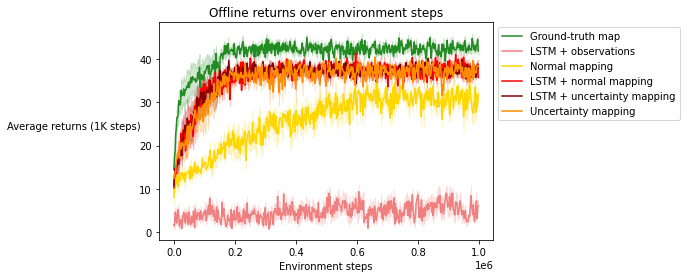

In [48]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k in plot_order:
    data = all_mapped_data[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

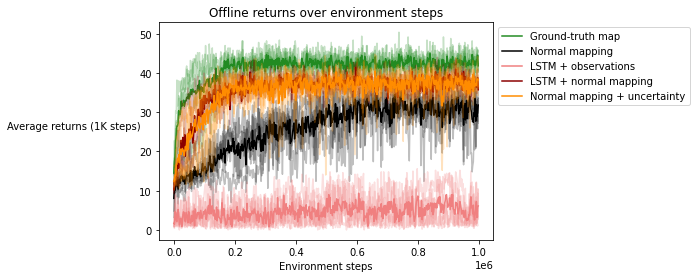

In [61]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k in plot_order:
    data = all_mapped_data[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0) 

    ax.plot(x, means, label=key, color=color)
    for d in data:
        ax.plot(x, d, color=color, alpha=0.25)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')